# Clasificación de Reseñas de Películas
La premisa es que cada reseña de película puede ser positiva o negativa, con base en el contenido de la reseña.


## Carga del Dataset


Ten en cuenta que el valor `num_words=10000` corresponde a usar solo las primeras 10000 palabras más frecuentes en el dataset de entrenamiento.


In [3]:
# Inicialmente estaba en 10000 pero en COLAB Free no alcanza a entrenar
NUM_WORDS=5000 

In [2]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=NUM_WORDS)

17464789/17464789 [==============================] - 2s 0us/step


Teniendo en cuenta que ninguna palabra puede exceder el índice 10000, como máximo tendremos este índice en los conjuntos de entrenamiento y prueba.

In [4]:
max([max(sequence) for sequence in train_data])

4999

Ahora veamos la primera reseña en el dataset de entrenamiento y su clasificación

In [5]:
print("Review: ", train_data[0])
print("Classification:", 'Positive' if train_labels[0] else 'Negative')

Review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
Classification: Positive


Como puedes notar, el review es una lista de números o índices de palabras. Sin embargo, podemos definir una función para decodificar cualquier reseña. (Ten en cuenta que alguna palabra no tan frecuente puede desaparecer.)

In [6]:
# Cargamos el diccionario que mapea las palabras a índices enteros
word_index = imdb.get_word_index()

# Reversamos para ahora mapear índices enteros en palabras
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
    )

# Definimos una función lambda para decodificar cualquier review.
# Los primeros tres índices corresponden a `padding`, `start of sequence` y `unknown`
decoded_review = lambda review: ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in review])

1641221/1641221 [==============================] - 1s 1us/step


In [7]:
decoded_review(train_data[2])

"? this has to be one of the worst films of the ? when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this ? excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

## Preparación de los datos

Dado que no podemos ingresar listas de enteros en la red neuronal, debemos convertirlas primero a "tensores". Para ello, debemos hacer lo siguiente:

* Ajustar las listas para que tengan la misma longitud.
* Convertirlas en tensores de enteros con tamaño `(samples, word_indices)`.
* Usar la primera capa de la red para que maneje estos tensores, esto es, usando una capa de tipo `Embedding`.
* Emplear One-hot encode para las listas. Es decir, enmascarar con unos y ceros la lista utilizando un vector de 10000 elementos. Si la reseña es `[1, 3]`, el vector codificado será `[0, 1, 0, 1, 0, 0, ...]`.

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=NUM_WORDS):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Como te puedes dar cuenta, con `vectorize_sequences` cumplimos las condiciones descritas antes. 

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Ahora, vectorizamos también las etiquetas y las adecuamos en términos de formato.

In [10]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Hasta este punto, ya la información está lista para ser ingresada a la red neuronal.

## Construcción de la red


En este caso, construirémos una red con dos capas ocultas, ambas con 16 elementos y una capa final con un único elemento. Fíjate en las funciones de activación, estas tienen mucho que ver con lo que hemos visto en clase.

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Compilamos el modelo definiendo un optimizador y la función de pérdida adecuada para clasificación binaria. Si deseas cambiar de optimizador, recuerda que puedes usar aquellos disponibles en `keras.optimizers`.

In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Primero, antes de pasar a entrenar la red, debemos definir un dataset de validación. Esto se hace para monitorear la exactitud del modelo en datos que no ha utilizado antes. Para ello, creamos una colección con 10000 muestras del dataset original.

In [13]:
x_val = x_train[:NUM_WORDS]
partial_x_train = x_train[NUM_WORDS:]

y_val = y_train[:NUM_WORDS]
partial_y_train = y_train[NUM_WORDS:]

## Entrenamiento de la red
Ahora sí, procedemos a entrenar el modelo con 20 épocas, con mini-batches de 512 muestras y utilizando los datos de validación antes definidos.


In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
40/40 [==============================] - 6s 21ms/step - loss: 0.4985 - accuracy: 0.7850 - val_loss: 0.3654 - val_accuracy: 0.8662
Epoch 2/20
40/40 [==============================] - 0s 10ms/step - loss: 0.3101 - accuracy: 0.8877 - val_loss: 0.3083 - val_accuracy: 0.8812
Epoch 3/20
40/40 [==============================] - 0s 12ms/step - loss: 0.2511 - accuracy: 0.9091 - val_loss: 0.2849 - val_accuracy: 0.8860
Epoch 4/20
40/40 [==============================] - 0s 10ms/step - loss: 0.2217 - accuracy: 0.9182 - val_loss: 0.2952 - val_accuracy: 0.8814
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 0.1993 - accuracy: 0.9255 - val_loss: 0.2901 - val_accuracy: 0.8842
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 0.1832 - accuracy: 0.9323 - val_loss: 0.2930 - val_accuracy: 0.8834
Epoch 7/20
40/40 [==============================] - 0s 11ms/step - loss: 0.1717 - accuracy: 0.9361 - val_loss: 0.3477 - val_accuracy: 0.8652
Epoch 8/20
40

¿Qué información tiene `history_dict`?

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Ahora veamos cómo estuvo la función de pérdida durante el proceso de entrenamiento y validación

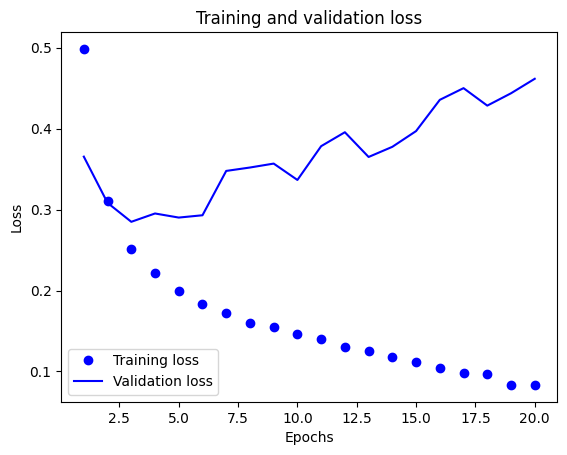

In [19]:
import matplotlib.pyplot as plt


loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Seguidamente, hacemos lo mismo con el accuracy durante el proceso de entrenamiento y validación

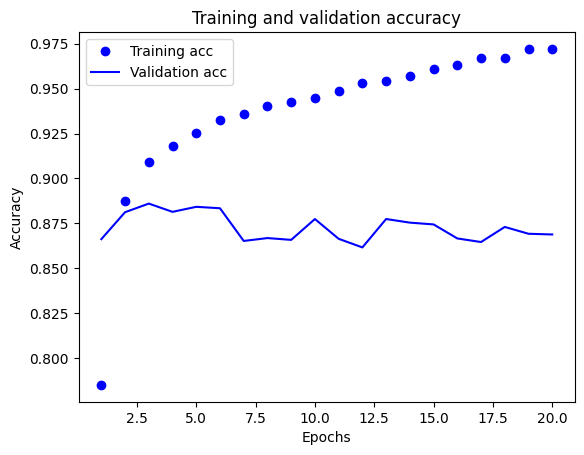

In [21]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluación del modelo

In [22]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5125 - accuracy: 0.8531


Si observamos, hemos obtenido un 83.68% de accuracy, un valor no tan bueno, si tenemos en cuenta que en el estado del arte es de 95%. ¿Es posible mejorar este valor? Sí, y la respuesta está en las gráficas que obtuvimos antes. Es decir, podemos volver a implementar el modelo y entrenamiento, pero esta vez con menos épocas, justo antes de que comience a degenerarse la dinámica del accuracy/loss.

In [23]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 1s 8ms/step - loss: 0.4626 - accuracy: 0.8082
Epoch 2/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2880 - accuracy: 0.8926
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2378 - accuracy: 0.9097
Epoch 4/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9170


Evaluando de nuevo, observamos que ahora nuestro accuracy es de 88.47%.

In [24]:
results = model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.2935 - accuracy: 0.8820
